# Beyong GLM: Delta Boosting Machine 
                       --- A Real Data-Set Analysis Case

Author: Simon Lee, FCAS, ASA, Regional Head of Big Data and Analytics


### Load packages and setup parameters...

In [1]:
## Load Packages
require(delta)
require(gbm)
require(mgcv)
require(stringr)
require(plyr)
require(reshape2)
require(ggplot2)

## Create Directories for code and data
current_directory = getwd()
setwd(paste0(current_directory, "/Data/"))

load("workspace.rData")

Parent.Directory = paste0(current_directory, "/Data/")
Data.Directory = paste0(current_directory, "/Data/")
Code.Directory = paste0(current_directory, "/Code/")

Loading required package: delta
Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded delta 0.1
Loading required package: gbm
Warning message:
"package 'gbm' was built under R version 3.2.5"Loaded gbm 2.1.1

Attaching package: 'gbm'

The following objects are masked from 'package:delta':

    basehaz.gbm, calibrate.plot, checkID, checkMissing, checkOffset,
    checkWeights, gbm.conc, gbm.loss, gbm.more, gbm.perf, gbm.roc.area,
    gbmCluster, gbmCrossValErr, gbmCrossValModelBuild,
    gbmCrossValPredictions, gbmDoFold, getCVgroup, getStratify,
    getVarNames, guessDist, interact.gbm, ir.measure.auc,
    ir.measure.conc, ir.measure.map, ir.measure.mrr, ir.measure.ndcg,
    perf.pairwise, permutation.test.gbm, plot.gbm, pretty.gbm.tree,
    print.gbm, quantile.rug, reconstructGBMdata, relative.influence,
    shrink.gbm, shrink.gbm.pred, summary.gbm, test.gbm,
    test.relative.influence, validate.

### Load data...

In [ ]:
lossdata = read.csv(paste0(Data.Directory,"GBMtoGLM_CustomerDatabase.csv"))

### What does it look like...

In [2]:
head(lossdata)

ContractID,VehicleID,Year,Exposure,ClaimsCount,ClaimsCost,CustomerGender,CustomerOccupation,CustomerType,AgeDriver,...,ClaimsHistoryOverFiveYears_WhenLastDamageClaims,ClaimsHistoryOverTenYears_AllExceptDamageClaimsCount,PremiumPayment.Numeric,DistanceDriven.Numeric,ClaimsHistoryOverFiveYears_WhenLastDamageClaims.Numeric,sample,DBM_poisson1.prediction,GBM_poisson1.prediction,GLM_poisson1.prediction,DBM_poisson2.prediction
192699,6834,2013,0.54520548,0,0,MAN,INDEPENDANT,PRIVATE,43,...,y_+,0,4,NA,6,0.7209039,0.068312145,0.065808136,0.060551157,0.068294184
130353,6835,2013,0.64383562,0,0,MAN,INDEPENDANT,PRIVATE,46,...,y-4,1,4,7,4,0.8757732,0.106011507,0.106102343,0.095198143,0.105640702
130353,6835,2014,0.69041096,0,0,MAN,INDEPENDANT,PRIVATE,47,...,y-5,1,4,7,5,0.7609823,0.107107520,0.105523120,0.095653281,0.105997815
130353,6835,2013,0.30958904,0,0,MAN,INDEPENDANT,PRIVATE,45,...,y-4,1,4,7,4,0.8861246,0.055542444,0.056136203,0.049017843,0.058476845
130353,6835,2014,0.30958904,0,0,MAN,INDEPENDANT,PRIVATE,46,...,y-5,1,4,7,5,0.4564810,0.048720541,0.048761856,0.045929626,0.048879045
130353,6835,2013,0.04657534,0,0,MAN,INDEPENDANT,PRIVATE,46,...,y-4,1,4,7,4,0.1663718,0.007668918,0.007675489,0.006886674,0.007642093


### Simple Feature Generation...

In [ ]:
## Convert Categorical into Numeric
lossdata$PremiumPayment.Numeric = as.numeric(factor(lossdata$PremiumPayment,levels(lossdata$PremiumPayment)[c(2,4,1,5,3)]))
lossdata$DistanceDriven.Numeric = as.numeric(lossdata$DistanceDriven)
lossdata$DistanceDriven.Numeric[lossdata$DistanceDriven.Numeric==8] = NA
lossdata$ClaimsHistoryOverFiveYears_WhenLastDamageClaims.Numeric = 
                    as.numeric(lossdata$ClaimsHistoryOverFiveYears_WhenLastDamageClaims)

## Remove a handful of missing data for GLM
lossdata = lossdata[!is.na(lossdata$Vehicle_Age),]
lossdata = lossdata[!is.na(lossdata$ClaimsHistoryOverTenYears_GlassBreakageClaimsCount),]
lossdata = lossdata[!is.na(lossdata$ClaimsHistoryOverTenYears_AllExceptDamageClaimsCount),]
lossdata = lossdata[lossdata$PremiumPayment != "ONE SHOT PAYMENT",]
lossdata$PremiumPayment = factor(lossdata$PremiumPayment)

### Run Models...

In [ ]:
## Model Parameters setting
set.seed(12345)
dbm.shrinkage = 0.01
gbm.shrinkage = 0.01
alpha = 5
ntree = 2500
minobs = 50
interaction.depth = 4
train.fraction = 0.8
test.fraction = 0.2

## Setting random sampling
lossdata$sample = runif(nrow(lossdata))

## DBM formula
dbm.formula = ClaimsCount ~ CustomerGender + CustomerType + AgeDriver + AgeDrivingLicense + 
                            AgeContract + PremiumPayment + UsageType + DistanceDriven.Numeric +  
                            Vehicle_Age + Vehicle_Value + Vehicle_PowerValueKW + Vehicle_DoorsCount +
                            Vehicle_PlacesCount + Vehicle_Length + Vehicle_Width + 
                            Vehicle_CylindersCount + Vehicle_WeightOverPowerRatio + 
                            ClaimsHistoryOverTenYears_DamageClaimsCount + 
                            ClaimsHistoryOverFiveYears_WhenLastDamageClaims.Numeric + 
                            ClaimsHistoryOverTenYears_TPLClaimsCount + 
                            ClaimsHistoryOverTenYears_NotAtFaultTPLClaimsCount 

## GBM formula
var = all.vars(dbm.formula)
gbm.formula = as.formula(paste0(var[1],"~ offset(Exposure) +", paste(var[-1], collapse=" + ")))

## GLM formula
var.glm = gsub(".Numeric","",var)
glm.formula = as.formula(paste0(var[1],"~ offset(Exposure) +", paste(var.glm[-1], collapse=" + ")))

## Run DBM
DBM_poisson <- delta(formula = dbm.formula ,
              data=lossdata[lossdata$sample < train.fraction,],
              distribution = "poisson",
              n.trees = ntree,
              exposure = Exposure,
              interaction.depth = interaction.depth, 
              n.minobsinnode = minobs,
              shrinkage = dbm.shrinkage,
              bag.fraction = 0.5,
              train.fraction =  1-test.fraction,
              keep.data = FALSE,
              verbose = T)


# save(DBM_poisson, file = paste(Code.Directory,"Stage1_DBM_poisson.rdata",sep=""))
iter_poisson = gbm.perf(DBM_poisson, plot.it = F,method="test")

### Rank variable and interaction importance...

In [ ]:
variable.importance = relative.influence(DBM_poisson, iter_poisson, T, T)
prediction_DBM_poisson_stage1 = lossdata$Exposure * exp(predict.gbm(DBM_poisson, lossdata, iter_poisson))
lossdata$DBM_poisson1.prediction = prediction_DBM_poisson_stage1

library(doParallel)
cl <- makeCluster(6)
registerDoParallel(cl)
interaction.strength = foreach(i=1:(length(DBM_poisson$var.names)-1)) %dopar%  {
  require(gbm)
  temp = rep(NA,length(DBM_poisson$var.names))
  for (j in (i+1):length(DBM_poisson$var.names)){
    temp[j] = interact.gbm(DBM_poisson,lossdata,c(i,j),iter_poisson) 
  }
  temp
}
stopCluster(cl)

interaction.strength = do.call("rbind",interaction.strength)

importance.threshold = 20
selected.variable = variable.importance[1:importance.threshold]

interaction.threshold = 0.075
interaction.index.temp = which(interaction.strength>interaction.threshold )
interaction.index = cbind(i = interaction.index.temp, j = interaction.index.temp, 
                          strength = interaction.strength[interaction.index.temp])
interaction.index[,2]= ((interaction.index.temp -1) %/% length(DBM_poisson$var.names)) +1
interaction.index[,1]= ((interaction.index.temp -1) %% length(DBM_poisson$var.names)) +1
interaction.index = interaction.index[order(interaction.index[,3],decreasing = T),]

interaction.name =interaction.index
interaction.name[,1:2] = DBM_poisson$var.names[interaction.index[,1:2]]
interaction.name[,3] = as.numeric(interaction.name[,3] )
interaction.name = cbind(interaction.name,interaction.name[,rep(1,3)])
interaction.name[,4] = interaction.name[,1] %in% names(selected.variable)
interaction.name[,5] = interaction.name[,2] %in% names(selected.variable)
interaction.name[,6] = interaction.name[,1] %in% names(selected.variable) * 
                        interaction.name[,2] %in% names(selected.variable)

# save(DBM_poisson, interaction.strength, variable.importance, 
#      prediction_DBM_poisson_stage1, interaction.name, selected.variable, 
#      file = paste(Code.Directory, "Stage1_DBM_poisson.rdata", sep=""))

### ----- Stage 1C Full blown modeling with GLM ---- ###

GLM1 = glm(formula = glm.formula, data=lossdata[lossdata$sample < train.fraction,], family = poisson)
lossdata$GLM_poisson1.prediction <-  predict(GLM1,lossdata,type="response")
# save.image("workspace.rData")

### Create simplified model...

In [ ]:
variable_stage2 = DBM_poisson$var.names
dbm.stage2.formula = dbm.formula

interaction.selected = interaction.name[interaction.name[,6] == "1",1:2]
interaction.matrix = diag(1,length(variable_stage2))
for (row in 1:nrow(interaction.selected)){
  temp = which(variable_stage2 %in% interaction.selected[row,])
  cat(temp,"\n")
  interaction.matrix[min(temp),max(temp)] = 1
}
interaction.matrix[lower.tri(interaction.matrix)] = t(interaction.matrix)[lower.tri(interaction.matrix)]


DBM_poisson_stage2 <- delta(formula = dbm.stage2.formula ,
                     data=lossdata[lossdata$sample < train.fraction,],
                     distribution = "poisson",
                     n.trees = ntree,
                     interaction.matrix = interaction.matrix,
                     interaction.depth = 2, 
                     n.minobsinnode = minobs,
                     shrinkage = dbm.shrinkage*2,
                     bag.fraction = 0.5,
                     train.fraction =   1-test.fraction,
                     keep.data = FALSE,
                     verbose = T)

iter_poisson = gbm.perf(DBM_poisson_stage2, plot.it = F)

variable.importance = relative.influence(DBM_poisson_stage2, iter_poisson, T, T)
prediction_DBM_poisson_stage2 = lossdata$Exposure * exp(predict(DBM_poisson_stage2, lossdata, iter_poisson))
lossdata$DBM_poisson2.prediction = prediction_DBM_poisson_stage2

### Rate table extraction...

In [ ]:
source(paste(Code.Directory,"differential extraction.R",sep=""))

DBM_object = diff_extract(DBM_poisson_stage2,lossdata, iter_poisson)
Var_list = DBM_object[[1]]
relativity_list = DBM_object[[2]]

offset = 0

for (i in 1:length(Var_list)){
  Variable = DBM_poisson_stage2$var.names[Var_list[[i]]]
  temp= relativity_list[[i]]
  temp1 = data.frame(lossdata[lossdata$sample  <train.fraction,Variable])
  names(temp1) = Variable
  temp1$order = 1:nrow(lossdata[lossdata$sample  <train.fraction,])
  fix_factor= merge(temp1, temp, by=Variable,sort=F, all.x= T)
  fix_factor = fix_factor[order(fix_factor$order),]
  offset = offset + fix_factor$relativity
  cat(Variable,"\t\terror: ",sum(is.na(offset)),"\t\t# of unique relativitys: ",length(unique(offset)),"\n")
}
prediction_DBM = predict(DBM_poisson_stage2,lossdata[lossdata$sample  <train.fraction,],n.tree =iter_poisson) 

### To show that rate table is working fine.
unique(round(prediction_DBM -offset,10))
# save(DBM_poisson_stage2, variable.importance, prediction_DBM_poisson_stage2, DBM_object, 
#      file = paste(Code.Directory,"Stage2_DBM_poisson.rdata",sep=""))
# save.image("workspace.rData")

### Diagnostics...

### Actual by Predicted plot

For continuous responses, the Actual by Predicted plot shows how well the model fits the data. A diagonal line represents the locus of where predicted and actual values are the same. For a perfect fit, all the points would be on this diagonal.

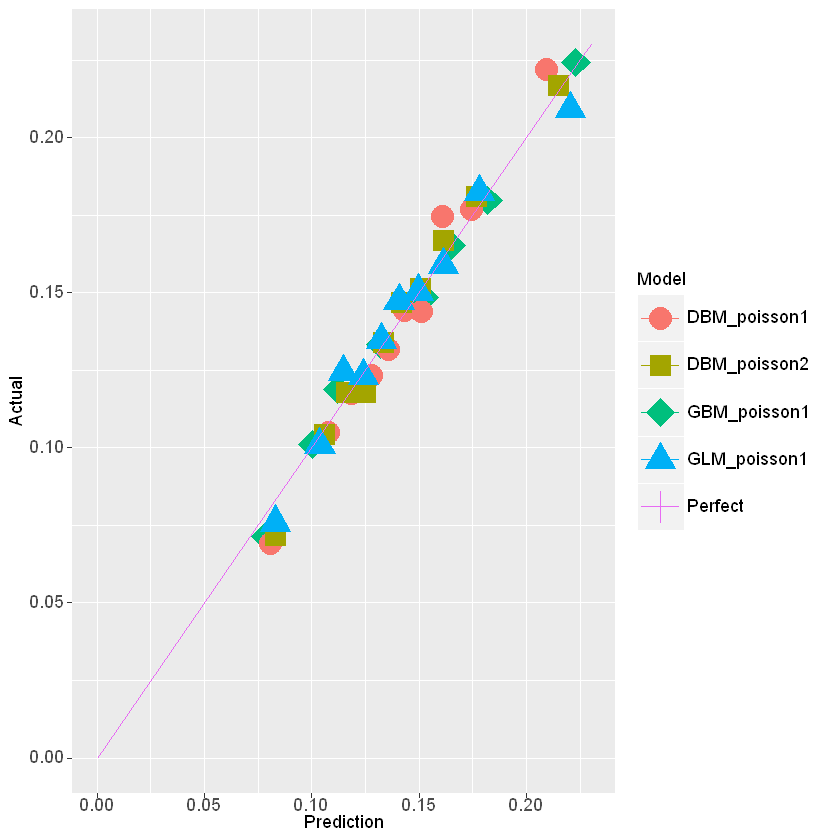

In [2]:
model.list = c("GBM_poisson1","DBM_poisson1","DBM_poisson2","GLM_poisson1")
model.label = c("GBM_poisson1","DBM_poisson1","DBM_poisson2","GLM_poisson1")

Lift.data = NULL
bucket = 10
sum.Exposure = sum(lossdata$Exposure[lossdata$sample >train.fraction])*1.000000001
for (model.name in model.list){
  temp = lossdata[lossdata$sample>train.fraction,][c(paste(model.name,".prediction",sep=""),"Exposure","ClaimsCount")]
  temp[paste(model.name,".link",sep="")] = temp[paste(model.name,".prediction",sep="")] /temp$Exposure
  temp = temp[order(temp[paste(model.name,".link",sep="")]),]  
  temp$Model = ceiling(cumsum(temp$Exposure*bucket/sum.Exposure))
  temp1 = ddply(temp, "Model", 
                function(x) data.frame(Prediction = sum(x[[paste(model.name,".prediction",sep="")]])/sum(x$Exposure), 
                                                      Actual = sum(x$ClaimsCount)/sum(x$Exposure)))
  temp1$Model = model.name
  Lift.data = rbind(Lift.data, temp1)
}

yrange=ceiling(max(Lift.data[,2:3]/0.01))*0.01

perfect.line = data.frame(prediction = range(Lift.data[,2:3]), actual = range(Lift.data[,2:3]))
perfect.line=rbind(c(0,0),perfect.line, c(yrange, yrange))
perfect.line$Model = "Perfect"
                
ggplot(data = Lift.data, aes(x = Prediction, y = Actual, colour = Model, shape = Model, fill=Model)) + 
                scale_shape_manual(values=c(21:24,3,4,46,8)) +
                geom_point(size = 6) +
                geom_line(data = perfect.line, aes(x= prediction, y= actual)) +
                theme(title = element_text(size = rel(1)),
                      axis.text= element_text(size = rel(1)),
                      legend.key.size = unit(1,"cm"),
                      legend.text =element_text(size = rel(1))) +
                scale_x_continuous(limits=c(0,ceiling(max(Lift.data[,2:3]/0.01))*0.01)) +
                scale_y_continuous(limits=c(0,ceiling(max(Lift.data[,2:3]/0.01))*0.01))

### Double Lift Plot for GBM model against GLM model

Double lift charts are similar to simple quantile plots, we sort based on the ratio of the two models’ predicted loss costs. Double lift charts directly compare the results of two models.

Steps in creating a double lift chart:
1. Calculate the ratio of (Model A predicted loss cost)/(Model B predicted loss cost).
2. Sort the data set based on the ratio calculated above.
3. Bucket the data into quantiles (deciles, quintiles, etc.).
4. For each bucket, plot three quantities:
    
    a. The model A predicted loss cost.
    
    b. The model B predicted loss cost.
    
    c. The actual loss cost.
 
We then see which model more closely matches the actual loss costs.

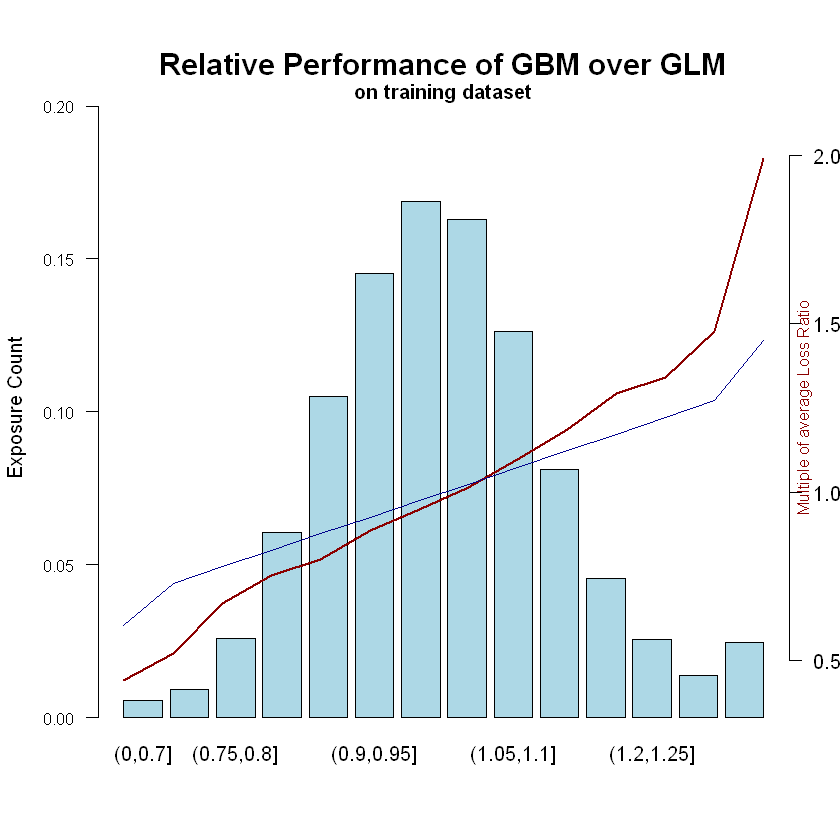

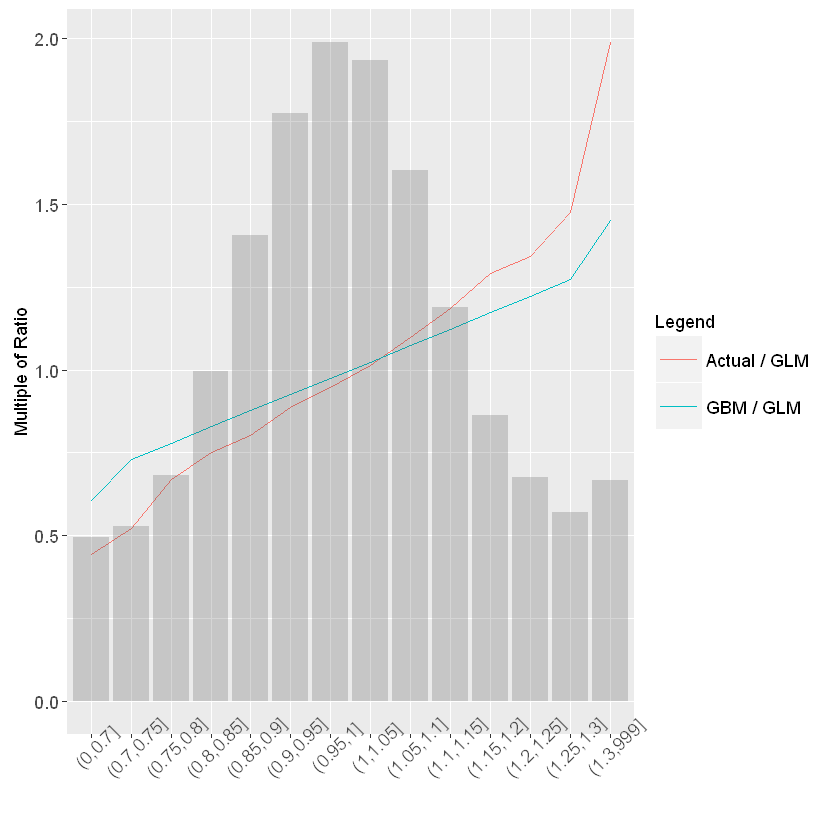

In [6]:
source(paste(Code.Directory,"Lift.Report.R",sep=""))

Training.Double.Lift = Double.Lift(lossdata[lossdata$sample < train.fraction,], 
                                   "GBM_poisson1.prediction","ClaimsCount","GLM_poisson1.prediction","Exposure",
                                   by.variable=NULL,10, bin =c(0,seq(0.7,1.3,0.05),999), balance = TRUE, plot = TRUE, 
                                   header = "Relative Performance of GBM over GLM",name = "on training dataset")

Training.Double.Lift$Exposure2 = Training.Double.Lift$eexp/max(Training.Double.Lift$eexp) * 
                        diff(range(Training.Double.Lift[,c((length(Training.Double.Lift)-1):length(Training.Double.Lift))])) + 
                        min(Training.Double.Lift[,c((length(Training.Double.Lift)-1):length(Training.Double.Lift))])

exp.plot = melt(Training.Double.Lift[,c("index_band","Exposure2")], id.vars="index_band")
colnames(exp.plot) = c("index_band","Name", "Exposure")

double.lift.data=Training.Double.Lift[,c("index_band","LR","dislocation")]
names(double.lift.data)=c("index_band","Actual / GLM","GBM / GLM")
new.plot = melt(double.lift.data, id.vars="index_band")
colnames(new.plot)= c("index_band" ,"Legend", "dislocation")

ggplot() + 
  geom_line(data=new.plot, 
            aes(x = index_band, y = dislocation, group=Legend, color = Legend),
            size=0.5) +
  geom_bar(data=exp.plot,
                 aes(x=index_band, stat="bin", weight=Exposure), 
                 alpha=0.25) +
  xlab("") +
  ylab("Multiple of Ratio") +
  theme(title = element_text(size = rel(1)),
        axis.text.x = element_text(angle=45),
        axis.text = element_text(size = rel(1)), 
        legend.key.size = unit(1,"cm"), 
        legend.text = element_text(size = rel(1)))
